In [1]:
!pip install transformers

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
np.random.seed(123)
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터 확인

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/train_review.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test_review.csv').dropna(how='any')

In [5]:
# from sklearn.model_selection import train_test_split
# train_data, validation_data = train_test_split(train_data, test_size=0.3, random_state=42) 

In [6]:
train_data.reset_index(drop=True,inplace=True)
#validation_data.reset_index(drop=True,inplace=True)

In [7]:
train_data.shape,test_data.shape

((50000, 2), (14999, 2))

In [8]:
train_data.head(20)

,기업한줄평,평점
0,절대가지마세요 몸 다 상합니다 부서 절대요,0
1,욕심없는 사람에게 추천 도태되는 게 조금이라도 두려운 사람에겐 비추,0
2,팀 간의 상하관계가 분명하고 상사는 부하직원에게 일을 몰아줌,0
3,애경 그룹내 작지만 꾸준한 성장을 하는 회사소소한 복리후생이 있고약간은 보수적이나 ...,1
4,다른 대기업보다 급여가 높으며 사원들도 인성좋고 착함,1
5,워라벨 최상급 연봉은 섭섭하지 않다,1
6,실적압박이 많이 심한 회사입니다 계속 후퇴하고있는 회사입니다,0
7,업계 최고 기업이라는 자부심을 가질 수 있지만 조금 박봉이라는 생각,0
8,일하는 업무에 비해 돈을 많이줌기업문화가 매우 떨어짐,1
9,본인이 마음만 먹는다면 얇고 길게 다닐 수 있는 기업,0


In [9]:
train_data.평점.value_counts()

0    25065
1    24935
Name: 평점, dtype: int64

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

In [11]:
sentence_lens = []

for txt in train_data.기업한줄평:
  sentence = len(txt)
  sentence_lens.append(sentence)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


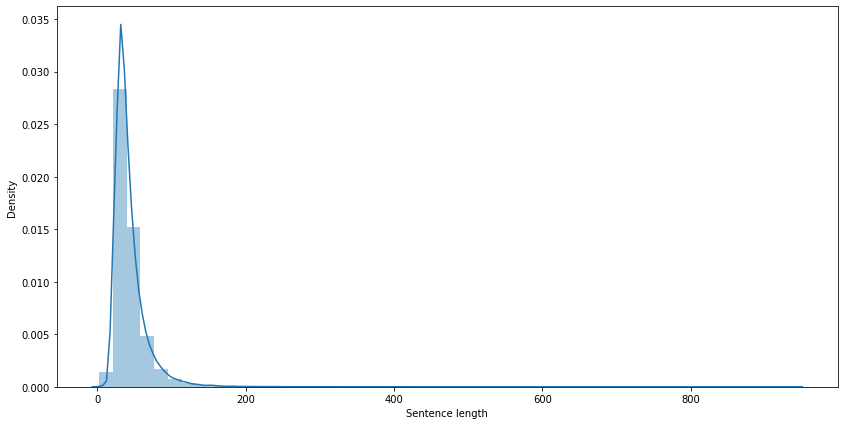

In [12]:
import seaborn as sns

fig = plt.figure(figsize=(14,7))
sns.distplot(sentence_lens)
plt.xlabel('Sentence length');

In [13]:
import pandas as pd
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import ElectraForSequenceClassification, AdamW
from tqdm.notebook import tqdm

In [14]:
# GPU 사용
device = torch.device("cuda")

## 데이터셋 준비

In [15]:
class ReviewDataset(Dataset):
  
  def __init__(self, df):
    # 일부 값중에 NaN이 있음...
    self.dataset = df
    # 중복제거
    self.dataset.drop_duplicates(subset=['기업한줄평'], inplace=True)
    self.tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

    #print(self.dataset.describe())
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 0:2].values
    text = row[0]
    y = row[1]

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=200,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask, y

In [16]:
train_dataset = ReviewDataset(train_data)
# validation_datasest = ReviewDataset(validation_data)
test_dataset = ReviewDataset(test_data)

## 모델 

In [17]:
model = ElectraForSequenceClassification.from_pretrained("beomi/KcELECTRA-base").to(device)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.out_proj.bias', 'classifier

In [18]:
# 모델 레이어 보기
model

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(50135, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

## 학습

In [19]:
epochs = 3
batch_size = 16

In [20]:
optimizer = AdamW(model.parameters(), lr=1e-5)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# validataion_loader = DataLoader(validation_datasest, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [21]:
losses = []
accuracies = []

for i in range(epochs):
  total_loss = 0.0
  correct = 0
  total = 0
  batches = 0

  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device).to(torch.int64), attention_mask=attention_masks_batch.to(device).to(torch.int64))[0]
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y_batch).sum()
    total += len(y_batch)

    batches += 1
    if batches % 100 == 0:
      print("Batch Loss:", total_loss, "Accuracy:", correct.float() / total)
  
  losses.append(total_loss)
  accuracies.append(correct.float() / total)
  print("Train Loss:", total_loss, "Accuracy:", correct.float() / total)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Batch Loss: 60.31057742238045 Accuracy: tensor(0.7362, device='cuda:0')
Batch Loss: 104.55256456136703 Accuracy: tensor(0.7791, device='cuda:0')
Batch Loss: 147.2078004926443 Accuracy: tensor(0.7917, device='cuda:0')
Batch Loss: 189.48163411021233 Accuracy: tensor(0.7998, device='cuda:0')
Batch Loss: 227.61837843060493 Accuracy: tensor(0.8068, device='cuda:0')
Batch Loss: 266.62528919428587 Accuracy: tensor(0.8122, device='cuda:0')
Batch Loss: 303.8953448459506 Accuracy: tensor(0.8166, device='cuda:0')
Batch Loss: 340.5695832595229 Accuracy: tensor(0.8195, device='cuda:0')
Batch Loss: 377.03149631619453 Accuracy: tensor(0.8216, device='cuda:0')
Batch Loss: 413.35841688513756 Accuracy: tensor(0.8242, device='cuda:0')
Batch Loss: 452.195025190711 Accuracy: tensor(0.8249, device='cuda:0')
Batch Loss: 492.58849492669106 Accuracy: tensor(0.8235, device='cuda:0')
Batch Loss: 527.9953096434474 Accuracy: tensor(0.8255, device='cuda:0')
Batch Loss: 564.9551045149565 Accuracy: tensor(0.8269, dev

Batch Loss: 25.438643034547567 Accuracy: tensor(0.8950, device='cuda:0')
Batch Loss: 56.10364127531648 Accuracy: tensor(0.8909, device='cuda:0')
Batch Loss: 86.18501629307866 Accuracy: tensor(0.8844, device='cuda:0')
Batch Loss: 118.36262533441186 Accuracy: tensor(0.8797, device='cuda:0')
Batch Loss: 149.56308593973517 Accuracy: tensor(0.8780, device='cuda:0')
Batch Loss: 179.59945425763726 Accuracy: tensor(0.8765, device='cuda:0')
Batch Loss: 209.8985498547554 Accuracy: tensor(0.8759, device='cuda:0')
Batch Loss: 234.34379672072828 Accuracy: tensor(0.8794, device='cuda:0')
Batch Loss: 264.680659590289 Accuracy: tensor(0.8798, device='cuda:0')
Batch Loss: 295.60288888029754 Accuracy: tensor(0.8788, device='cuda:0')
Batch Loss: 324.06465998850763 Accuracy: tensor(0.8792, device='cuda:0')
Batch Loss: 354.68373942933977 Accuracy: tensor(0.8782, device='cuda:0')
Batch Loss: 384.28208989836276 Accuracy: tensor(0.8786, device='cuda:0')
Batch Loss: 415.8311395328492 Accuracy: tensor(0.8783, d

Batch Loss: 23.65886915847659 Accuracy: tensor(0.9038, device='cuda:0')
Batch Loss: 45.338913556188345 Accuracy: tensor(0.9109, device='cuda:0')
Batch Loss: 66.08948100730777 Accuracy: tensor(0.9148, device='cuda:0')
Batch Loss: 88.49790435656905 Accuracy: tensor(0.9144, device='cuda:0')
Batch Loss: 113.42515997961164 Accuracy: tensor(0.9116, device='cuda:0')
Batch Loss: 135.7899086549878 Accuracy: tensor(0.9118, device='cuda:0')
Batch Loss: 160.49798970669508 Accuracy: tensor(0.9097, device='cuda:0')
Batch Loss: 185.84820841997862 Accuracy: tensor(0.9089, device='cuda:0')
Batch Loss: 208.85840787738562 Accuracy: tensor(0.9090, device='cuda:0')
Batch Loss: 232.40206974372268 Accuracy: tensor(0.9091, device='cuda:0')
Batch Loss: 256.07260367274284 Accuracy: tensor(0.9095, device='cuda:0')
Batch Loss: 280.8350985683501 Accuracy: tensor(0.9093, device='cuda:0')
Batch Loss: 304.8037769496441 Accuracy: tensor(0.9088, device='cuda:0')
Batch Loss: 327.38106874376535 Accuracy: tensor(0.9091, d

In [22]:
losses, accuracies

([1163.4610071890056, 927.373458147049, 739.2206203714013],
 [tensor(0.8417, device='cuda:0'),
  tensor(0.8784, device='cuda:0'),
  tensor(0.9076, device='cuda:0')])

## 테스트 

In [23]:
model.eval()

test_correct = 0
test_total = 0

for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
  y_batch = y_batch.to(device)
  y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  _, predicted = torch.max(y_pred, 1)
  test_correct += (predicted == y_batch).sum()
  test_total += len(y_batch)

print("Accuracy:", test_correct.float() / test_total)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



Accuracy: tensor(0.8508, device='cuda:0')


## 결과

In [24]:
def convert_input_data(sentences):
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    MAX_LEN = 200
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [25]:

# 문장 테스트
def test_sentences(sentences):
    model.eval()
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
        
    results = outputs[0]
    results = results.detach().cpu().numpy()

    if np.argmax(results) == 1:
      return '긍정적인 기업 평가입니다.'
    else:
      return '부정적인 기업 평가입니다.'

In [26]:
from keras.preprocessing.sequence import pad_sequences

### Positive (긍정)

In [27]:
results = test_sentences(['나를 성장시켜주는 회사'])
print(results)

긍정적인 기업 평가입니다.


In [28]:
results = test_sentences(['다녀 본 곳 중 워라벨이 가장 훌륭한 회사였습니다'])
print(results)

긍정적인 기업 평가입니다.


In [29]:
results = test_sentences(['많이 배우고 경험을 쌓을 수 있다'])
print(results)

긍정적인 기업 평가입니다.


In [30]:
results = test_sentences(['복지가 괜찮다'])
print(results)

부정적인 기업 평가입니다.


In [31]:
results = test_sentences(['개발자가 대우 받으며 일할 수 있는 곳'])
print(results)

긍정적인 기업 평가입니다.


### Negative (부정)

In [32]:
results = test_sentences(['야근 많다'])
print(results)

부정적인 기업 평가입니다.


In [33]:
results = test_sentences(['꼰대 같은 상사'])
print(results)

부정적인 기업 평가입니다.


In [34]:
results = test_sentences(['내 능력이고 경력이 무시당하는 회사'])
print(results)

부정적인 기업 평가입니다.


In [35]:
results = test_sentences(['일이 많아서 조금 까다로운 상황이 많다'])
print(results)

부정적인 기업 평가입니다.


In [36]:
results = test_sentences(['재직당시 근로계약서도 작성안하던(현재는 작성중) 열악한 중소기업'])
print(results)

부정적인 기업 평가입니다.
